In [1]:
# python -m pip install opencv-contrib-python

import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

In [2]:
model = cv2.dnn.readNetFromTensorflow('models/frozen_inference_graph.pb', 'models/ssd_mobilenet_v2_coco_2018_03_29.pbtxt')
with open('models/object_detection_classes_coco.txt', 'r') as f:
    class_names = f.read().split('\n')

In [3]:
def detect_objects(image):
    image_height, image_width, _ = image.shape

    model.setInput(cv2.dnn.blobFromImage(image, size=(300, 300), swapRB=True, crop=False))
    output = model.forward()
    detections = []
    
    for detection in output[0,0,:,:]:
        score = float(detection[2])
        if score > 0.3:
            class_id = detection[1]
            class_name = class_names[int(class_id)-1]

            left = detection[3] * image_width
            top = detection[4] * image_height
            right = detection[5] * image_width
            bottom = detection[6] * image_height
            detections.append((left, top, right-left, bottom-top))

            cv2.rectangle(image, (int(left), int(top)), (int(right), int(bottom)), (0, 0, 255), thickness=3)
            cv2.putText(image, class_name, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    plt.imshow(image[...,::-1]);
    return detections

In [4]:
def display_trackers():
    print("*********************")
    print("1. BOOSTING")
    print("2. MIL")
    print("3. KCF")
    print("4. CSRT")
    print("5. TLD")
    print("6. MEDIANFLOW")
    print("7. GOTURN")
    print("8. Exit")
    print("=====================")

*********************
1. BOOSTING
2. MIL
3. KCF
4. CSRT
5. TLD
6. MEDIANFLOW
7. GOTURN
8. Exit


Select Tracker type :  0


*********************
1. BOOSTING
2. MIL
3. KCF
4. CSRT
5. TLD
6. MEDIANFLOW
7. GOTURN
8. Exit


Select Tracker type :  1


*********************
1. BOOSTING
2. MIL
3. KCF
4. CSRT
5. TLD
6. MEDIANFLOW
7. GOTURN
8. Exit


Select Tracker type :  2


An error occurred in this tracker...
*********************
1. BOOSTING
2. MIL
3. KCF
4. CSRT
5. TLD
6. MEDIANFLOW
7. GOTURN
8. Exit


Select Tracker type :  3


An error occurred in this tracker...
*********************
1. BOOSTING
2. MIL
3. KCF
4. CSRT
5. TLD
6. MEDIANFLOW
7. GOTURN
8. Exit


Select Tracker type :  4


*********************
1. BOOSTING
2. MIL
3. KCF
4. CSRT
5. TLD
6. MEDIANFLOW
7. GOTURN
8. Exit


Select Tracker type :  5


*********************
1. BOOSTING
2. MIL
3. KCF
4. CSRT
5. TLD
6. MEDIANFLOW
7. GOTURN
8. Exit


Select Tracker type :  6


*********************
1. BOOSTING
2. MIL
3. KCF
4. CSRT
5. TLD
6. MEDIANFLOW
7. GOTURN
8. Exit


Select Tracker type :  8


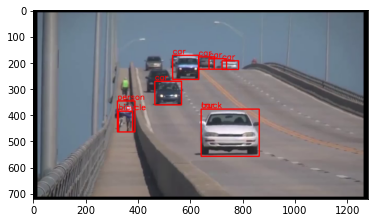

In [6]:
logging.basicConfig(filename='error.log', level=logging.ERROR, format='- %(levelname)s - %(message)s')

tracker_types = ['BOOSTING', 'MIL','KCF', 'CSRT', 'TLD', 'MEDIANFLOW', 'GOTURN','MOSSE']
while True:
    display_trackers()
    tr = int(input("Select Tracker type : "))
    tracker_type = tracker_types[tr-1]
    
    if tr == 8 :
        break
    elif   tr == 1:
        tracker = cv2.legacy_TrackerBoosting.create()
    elif tr == 2:
        tracker = cv2.TrackerMIL_create()
    elif tr == 3:
        tracker = cv2.TrackerKCF_create()
    elif tr == 4:
        tracker = cv2.legacy_TrackerCSRT.create()
    elif tr == 5:
        tracker = cv2.legacy_TrackerTLD.create()
    elif tr == 6:
        tracker = cv2.legacy_TrackerMedianFlow.create()
    elif tr == 7:
        tracker = cv2.TrackerGOTURN_create()   
    else:
        tracker = cv2.legacy_TrackerMOSSE.create()
    
    
    cap = cv2.VideoCapture('tracking_input720.mp4')
    if not cap.isOpened():
        print("Could not open video")
    else : 
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    ret , frame = cap.read()
    shape = frame.shape
    cp_frame = frame.copy()
    detections = detect_objects(cp_frame)

    out = tracker_type + '.mp4'
    video_out = cv2.VideoWriter(out, cv2.VideoWriter_fourcc(*'avc1'), 10, (width, height))
    
    try:
        multiTracker = cv2.legacy.MultiTracker_create()
        if detections is not None:
            for detection in detections:
                multiTracker.add(tracker, frame,  detection)

        while cap.isOpened():
            success, frame = cap.read()
            # plt.imshow(frame)
            if not success:
                break
            success, boxes = multiTracker.update(frame)

            for box in boxes:
                p1 = (int(box[0]), int(box[1]))
                p2 = (int(box[0] + box[2]), int(box[1] + box[3]))
                cv2.rectangle(frame, p1, p2, (0,0,255), 2, 1)

            cv2.imshow('MultiTracker', frame)
            video_out.write(frame)

            if cv2.waitKey(1) & 0xFF == 27:  # Esc pressed
                break

        cv2.destroyAllWindows()
        cap.release()

    except Exception as e :
        print('An error occurred in this tracker...')
        logging.exception(str(e))

#### `Outputs saved in tracked_object_videos`

In [ ]:
# # Check if the object is still visible in the frame
#     if tracker.update(frame):
        
#         bbox = tracker.get_position()
#         bbox = (int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
#         cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
#         cv2.putText(frame, "Tracking", (bbox[0], bbox[1] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
#     else:
#         # Object lost, perform re-detection
#         detections = detector.detect(frame)
#         if len(detections) > 0:
#             bbox = detections[0] 
#             tracker.init(frame, bbox)